# Redefining xG
This project aims to **"redefine" the Expected Goal index** (also known as *xG*), allowing to **create an index which takes more information into account when deciding the probability of scoring a goal**.

In this notebook, informations about games and players are taken from different sources, and joined in a dataset, which includes detailed info about **2 seasons of Serie A football (2022/23 and 2023/24 season)**. The dataset includes **player-related features**, like the attacker's **shot rating** and the goalkeeper's **overall rating**, and **contextual features**, like the shot's **body part** or the **goal difference** between the teams at the time of the shot.

This dataset is then used to train a model, using different algorithms, like *XGBoost* or *Random Forest*, or *ensemble methods* like *AdaBoost*. **Data Augmentation** techniques, like *Random Oversampling*, *SMOTE* or *ADASYN* have also been used to test if the model would benefit from having a more balanced dataset.

Other techniques have been used to analyse the model's performance or to improve them, respectively **Cross Validation** (in a *stratified* manner, to keep the folds balanced), and **Parameter Tuning**, to look for a model that could reach a better *f1 score*.

The model's output has been confronted with the xG values produced by a "competitor", *SofaScore*, in order to have a measure of quality for the model's predictions, as **the classic evaluation metrics**, like *precision*, *recall* or *f1 score*, **couldn't reflect the real quality of the model**, since they were based on the binary classifications, instead of the probabilities predicted by the model. For this reason, this notebook tries to reach xG numbers that get close to the competitor one, with **the target being the number of goals scored in the test dataset**.

Eventually, the model has been analysed by looking at **feature importance** by looking at the *Shapley values*, in order to have a global view of the "reasoning" behind the model's predictions, but also to **have a specific explanation of a single prediction**, being able to **understand which features influence a specific prediction for a specific shot**.

0) **Installing and Importing Libraries**

In [1]:
%pip install html_to_json
%pip install soccerdata
%pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.3/486.3 kB 24.9 MB/s eta 0:00:00
  Created wheel for undetected-chromedriver: filename=undetected_chromedriver-3.5.5-py3-none-any.whl size=47048 sha256=e12e024e07e3b83c546b8229314d4bd9e5bdf2755b2ae0f654a0630670847e49
  Stored in directory: /root/.cache/pip/wheels/cf/a1/db/e1275b6f7259aacd6b045f8bfcb1fcbc93827a3916ba55d5b7
Successfully built undetected-chromedriver
  Attempting uninstall: lxml
    Found existing installation: lxml 5.3.0


In [2]:
import requests # necessary for scraping
from bs4 import BeautifulSoup # necessary for scraping
import html_to_json # necessary for scraping
import json # necessary for scraping
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta  # necessary to find FIFA's version
baseUrl = "https://www.sofascore.com/api/v1/event/" # necessary for scraping
basePath = "/content/drive/MyDrive/AI/"
import math
import unidecode # necessary to avoid accents and special characters in players' names
import soccerdata as sd
from google.colab import drive
drive.mount('/content/drive')
from google.colab import output
from selenium.webdriver.common.by import By
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
import joblib
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import shap
pd.options.mode.chained_assignment = None


[01/07/25 17:22:11] INFO     No custom team name replacements found. You can configure these in       ]8;id=559673;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=825499;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py#90\90]8;;\
                             /root/soccerdata/config/teamname_replacements.json.                                   

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=720794;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=197001;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py#196\196]8;;\
                             /root/soccerdata/config/league_dict.json.                                             

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0.5) **Installing Selenium**: *Selenium* is necessary to send requests without having issues related to data inconsistency or network denials.

In [3]:
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [61.7 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,199 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,631 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubunt

In [4]:
!pip install chromedriver-autoinstaller

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

import time
from selenium import webdriver
import chromedriver_autoinstaller
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

# setup chrome options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# set path to chromedriver as per your configuration
chromedriver_autoinstaller.install()

# set the target URL
url = "https://www.sofascore.com/api/v1/event/"

# set up the webdriver
driver = webdriver.Chrome(options=chrome_options)

[01/07/25 17:23:43] INFO     Downloading chromedriver (131.0.6778.204)...                              ]8;id=26474;file:///usr/local/lib/python3.10/dist-packages/chromedriver_autoinstaller/utils.py\utils.py]8;;\:]8;id=754213;file:///usr/local/lib/python3.10/dist-packages/chromedriver_autoinstaller/utils.py#297\297]8;;\

# 1) Building the Shots List

1.1) **Getting The Base Shotmap**: Sofascore (through the previously set up *Selenium* webdriver) is scraped in order to get the base list of shots for the single game.

In [5]:
def getBaseShotmap(game, driver):
  url = baseUrl + str(game['game_id']) + "/shotmap"
  print(url)
  driver.get(url)
  content = driver.page_source
  soup = BeautifulSoup(content, 'lxml')
  js = html_to_json.convert(str(soup))
  js = js['html']
  js = js[0]['body']
  js = js[0]['pre']
  js = js[0]['_value']
  js = json.loads(js)
  js = js['shotmap']
  df = pd.DataFrame(js)
  df = df.sort_values(by=['time']).reset_index()
  return df

1.2) **Getting Teams' Elo Rating**: One of the first features being retrieved is both teams' *Elo rating*, which determines the team's strength **in that period**. It will later be found that **Elo rating is not a useful feature**. The function will get an Elo rating for the team in the match's day, or the first one found in the previous 31 days.

In [6]:
def getEloRating(team, dateString):
    if (team == "U.C Sampdoria"):
      team = "Sampdoria"
    year, month, day = dateString.split("-")
    year = int(year)
    month = int(month)
    day = int(day)
    dfElo = elo.read_team_history(team)
    for i in range(0, 31):
        if(len(dfElo[(dfElo.index.year == year) & (dfElo.index.month == month) & (dfElo.index.day == (day-i))]) == 0):
            eloTeam = dfElo[(dfElo.index.year == year) & (dfElo.index.month == month)].reset_index()
            break
    return int(eloTeam.loc[0]['elo'])

1.3) **Getting Teams' Lineups**: After Elo ratings, lineups are retrieved, through Sofascore, to have informations about the players playing in the match in both teams.

In [7]:
def getLineups(match):
    players = []
    ids = []
    url = baseUrl + str(match['game_id']) + "/lineups"
    driver.get(url)
    content = driver.page_source
    soup = BeautifulSoup(content, 'lxml')
    js = html_to_json.convert(str(soup))
    js = js['html']
    js = js[0]['body']
    js = js[0]['pre']
    js = js[0]['_value']
    js = json.loads(js)
    homePlayers = js['home']['players']
    homePlayers = pd.DataFrame(homePlayers)
    for i in homePlayers.index:
        player = homePlayers.loc[i]['player']
        players.append(player['name'])
        ids.append(player['id'])
    homePlayers['playerName'] = players
    homePlayers['id'] = ids
    homePlayers = homePlayers.drop(columns='player')
    homePlayers['team'] = match['home_team']

    homePlayers = homePlayers[['team', 'playerName', 'shirtNumber', 'position', 'substitute', 'id']]

    players = []
    ids = []
    awayPlayers = js['away']['players']
    awayPlayers = pd.DataFrame(awayPlayers)
    for i in awayPlayers.index:
        player = awayPlayers.loc[i]['player']
        players.append(player['name'])
        ids.append(player['id'])
    awayPlayers['playerName'] = players
    awayPlayers['id'] = ids
    awayPlayers = awayPlayers.drop(columns='player')
    awayPlayers['team'] = match['away_team']
    awayPlayers = awayPlayers[['team', 'playerName', 'shirtNumber', 'position', 'substitute', 'id']]
    lineups = pd.concat([homePlayers, awayPlayers])
    lineups = lineups.reset_index(drop=True)
    return lineups

1.4) **Getting FIFA/FC Version**: Since **the attacker and keeper ratings are based on their FIFA ratings**, the following function is used to get the closest FIFA database version to the match day, in order to get ratings as close as possible to the ones assigned to players in that time.

In [8]:
def findVersionByDate(versions, dateObject):
  versions = versions.iloc[::-1].reset_index()[:200]
  limit = dateObject + timedelta(days=30)
  for i in versions.index:
    versionDateObject = datetime.strptime(versions.loc[i]['update'], '%b %d, %Y').date()
    if dateObject <= versionDateObject <= limit:
      print("Version Found: " + str(versions.loc[i]['version_id']))
      return versions.loc[i]['version_id']
  limit = dateObject - timedelta(days=30)
  for i in versions.index:
    versionDateObject = datetime.strptime(versions.loc[i]['update'], '%b %d, %Y').date()
    if limit <= versionDateObject <= dateObject:
      print("Version Found: " + str(versions.loc[i]['version_id']))
      return versions.loc[i]['version_id']
  print("Version Not Found")

1.5) **Converting Coordinates to Distance & Angle**: Data from Sofascore is represented using x/y coordinates, which are not suitable for the model, so they are converted to *Distance and Angle*, which will be treated as two different features, with **very different influences on the model**.

In [9]:
def convertXY(x, y):
  baseX = 0
  baseY = 40
  distance = math.sqrt((x - baseX)**2 + (y - baseY)**2)
  angleRadiants = math.atan2(y - baseY, x - baseX)
  angle = math.degrees(angleRadiants)
  return int(distance), abs(int(angle))

1.6) **Get Player SoFIFA ID**: Informations about player ratings are retrieved through the *SoFIFA* website, thanks to the *SoccerData* library. This function allows to find the player's SoFIFA ID, in order to get his rating in the next function, at point 8. If the player can't be found, the *getLostPlayer* function, explained in point 7, will be called. If even this function can't find the player, the program will arbitrarily take the team goalkeeper's rating and return a rating based on that.

In [10]:
def getPlayerRating(df, i, home, fifaPlayers, pHome, pAway, sofifaSingle, game, position):
  if home == True:
    for j in pHome.index:
      if unidecode.unidecode(df.loc[i]['player']['name']) in unidecode.unidecode(pHome.loc[j]['player']):
        playerId = j
        rating = getShotRating(sofifaSingle,int(playerId))
        return rating

    for j in fifaPlayers.index:
      if unidecode.unidecode(df.loc[i]['player']['name']) in unidecode.unidecode(fifaPlayers.loc[j]['player']):
        playerId = j
        rating = getShotRating(sofifaSingle, int(playerId))
        return rating

    rating = getLostPlayer(df.loc[i]['player']['name'], game['home_team'], sofifaSingle)
    if(rating == 0):
      print(df.loc[i]['player']['name'] + " Not Found")
      f = open(basePath + "notFound.txt", "a")
      f.write(df.loc[i]['player']['name'] + ", Date: " + str(game['date']) + "\n")
      f.close()
      pHome = pHome.reset_index()
      referralId = pHome.loc[0]['player_id']
      rating = sofifaSingle.read_player_ratings(team=game['home_team'], player=int(referralId))['overallrating'].iloc[0]
      if position == "F":
        rating = int(rating)-10
      elif position == "M":
        rating = int(rating)-20
      elif position == "D":
        rating = int(rating)-30
      return rating
    return rating
  else:
    for j in pAway.index:
      if unidecode.unidecode(df.loc[i]['player']['name']) in unidecode.unidecode(pAway.loc[j]['player']):
        playerId = j
        rating = getShotRating(sofifaSingle, int(playerId))
        return rating

    for j in fifaPlayers.index:
      if unidecode.unidecode(df.loc[i]['player']['name']) in unidecode.unidecode(fifaPlayers.loc[j]['player']):
        playerId = j
        rating = getShotRating(sofifaSingle, int(playerId))
        return rating

    rating = getLostPlayer(df.loc[i]['player']['name'], game['away_team'], sofifaSingle)
    if(rating == 0):
      print(df.loc[i]['player']['name'] + " Not Found")
      f = open(basePath + "notFound.txt", "a")
      f.write(df.loc[i]['player']['name'] + ", Date: " + str(game['date']) + "\n")
      f.close()
      pAway = pAway.reset_index()
      referralId = pAway.loc[0]['player_id']
      rating = sofifaSingle.read_player_ratings(team=game['away_team'], player=int(referralId))['overallrating'].iloc[0]
      if position == "F":
        rating = int(rating)-10
      elif position == "M":
        rating = int(rating)-20
      elif position == "D":
        rating = int(rating)-30
      return rating
    return rating

1.7) **Find Lost Players**: This function is useful for players that can't be found, and that have been hardcoded to fill the dataset. The following players couldn't be found for differences between the players' names on Sofascore and the ones on SoFIFA, or for newly-promoted/relegated teams.

In [11]:
def getLostPlayer(lostName, lostTeam, sofifaSingle):
  sfPlayerIds = {
      "M'Bala Nzola": 240452,
      "Georgios Kyriakopoulos": 253213,
      "Gabriel Strefezza": 235949,
      "Renato Sanches": 235949,
      "Samuel Iling Junior": 230767,
      "Dan Ndoye": 257980,
      "Rafael Leão": 241721,
      "Zito Luvumbo": 259011,
      "Leandro Paredes": 207439,
      "Dodô": 234112,
      "Jesper Karlsson": 231836,
      "Ruslan Malinovskyi": 231969,
      "Frank Anguissa": 227236,
      "Uroš Račić": 244253,
      "João Ferreira": 252577,
      "Agustín Martegani": 262083,
      "Romelu Lukaku": 192505,
      "José Machín": 230817,
      "Emil Holm": 246656,
      "Victor Kristiansen": 259762,
      "Mattéo Guendouzi": 236496,
      "Juan Jesus": 200752,
      "Jesper Lindstrøm": 245741,
      "Walid Cheddira": 268511,
      "Jovane Cabral": 244193,
      "Mohamed Kaba": 263469,
      "Berkan Kutlu": 259675,
      "Jens Cajuste": 244472,
      "Emil Konradsen Ceide": 245537,
      "Samu Castillejo": 210617,
      "Pol Lirola": 235875,
      "Natan": 277537,
      "Aleksei Miranchuk": 214092,
      "Yann Bisseck": 241736,
      "Simy": 219496,
      "Thomas Kristensen": 261573,
      "Pedro Pereira": 230824,
      "Szymon Żurkowski": 239732,
      "Matteo Gabbia": 240277,
      "Alberto Cerri": 213829,
      "Santiago Pierotti": 236758,
      "Hamed Junior Traorè": 240787,
      "Tijjani Noslin": 264257,
      "Karol Świderski": 224301,
      "Angeliño": 220651,
      "Daniel Silva": 270686,
      "Vitinha": 236758,
      "Juan Cabal": 251870,
      "Marcus Pedersen": 243481,
      "Rodrigo Becão": 238621,
      "Pablo Marí": 206654,
      "Mehdi Léris": 240660,
      "Abdelhamid Sabiri": 237499,
      "Fabio Depaoli": 235834,
      "Fabio Quagliarella": 159261,
      "Cyriel Dessers": 222262,
      "David Okereke": 233732,
      "Luca Zanimacchia": 235935,
      "Charles Pickel": 233884,
      "Giacomo Quagliata": 255580,
      "Cristian Buonaiuto": 222153,
      "Matteo Bianchetti": 205363,
      "Grīgorīs Kastanos": 237335,
      "Federico Bonazzoli": 223137,
      "Tonny Vilhena": 203535,
      "Antonio Candreva": 173221,
      "Dylan Bronn": 235565,
      "Federico Fazio": 179847,
      "Arkadiusz Reca": 234760,
      "Mehdi Bourabia": 198220,
      "Mattia Caldara": 220477,
      "Kevin Agudelo": 243253,
      "Domenico Berardi": 210935,
      "Grégoire Defrel": 202851,
      "Kristian Thorstvedt": 242725,
      "Kaan Ayhan": 207790,
      "Davide Frattesi": 239807,
      "Matheus Henrique": 254487,
      "Jeremy Toljan": 214622,
      "Filip Kostić": 208574,
      "Petko Hristov": 239998,
      "David Strelec": 264692,
      "Nikola Vlašić": 241095,
      "Giulio Maggiore": 236368,
      "Erik Botheim": 239125,
      "Destiny Udogie": 259583,
      "Pasquale Mazzocchi": 239679,
      "Beto": 251892,
      "Min-jae Kim": 237086,
      "Arthur Cabral": 246186,
      "Paolo Ghiglione": 230912,
      "Santiago Ascacíbar": 232244,
      "Luka Lochoshvili": 258464,
      "Emanuele Valeri": 258714,
      "Tomás Rincón": 191053,
      "Francesco Caputo": 189053,
      "Jaime Báez": 231050,
      "Emanuel Aiwu": 243442,
      "Gonzalo Escalante": 219391,
      "Leonardo Sernicola": 233968,
      "Johan Vásquez": 244349,
      "Andrea Pinamonti": 235842,
      "Simone Bastoni": 225189,
      "Emmanuel Gyasi": 220491,
      "Gian Marco Ferrari": 224808,
      "Rogério": 241629,
      "Miguel Veloso": 178007,
      "Boulaye Dia": 246242,
      "Filip Đuričić": 193881,
      "Omar Colley": 226536,
      "Valerio Verre": 205531,
      "Samuel Di Carmine": 186614,
      "Viktor Kovalenko": 228698,
      "Bartosz Bereszyński": 199763,
      "Manolo Gabbiadini": 198683,
      "Lassana Coulibaly": 230107,
      "Armand Laurienté": 243593,
      "Maxime López": 224030,
      "Agustín Álvarez": 258846,
      "Tommaso Augello": 240100,
      "Ronaldo Vieira": 233943,
      "Jakub Kiwior": 265693,
      "Krzysztof Piątek": 223113,
      "Domagoj Bradarić": 252000,
      "Diego Valencia": 243386,
      "Jeison Murillo": 201377,
      "Ethan Ampadu": 235735,
      "Luca D'Andrea": 271482,
      "Abdou Harroui": 241937,
      "Soualiho Meïté": 205391,
      "Mikael Ellertsson": 264436,
      "Daniel Ciofani": 178475,
      "Michele Castagnetti": 235163,
      "Janis Antiste": 255839,
      "Ruan": 263785,
      "Daniel Maldini": 255611,
      "Kelvin Amian": 231235,
      "Flavius Daniliuc": 252017,
      "Dimitris Nikolaou": 237040,
      "Albin Ekdal": 181318,
      "Felix Afena-Gyan": 265187,
      "Daniele Verde": 225844,
      "Norbert Gyömbér": 220061,
      "Emil Bohinen": 234894,
      "Ilija Nestorovski": 199274,
      "Bruno Amione": 268679,
      "Ignacio Pussetto": 219536,
      "Gonzalo Villar": 244393,
      "Alex Ferrari": 219852,
      "Frank Tsadjout": 253071,
      "Daniele Montevago": 272511,
      "Lorenzo Pirola": 257368,
      "Gerard Yepes": 266069,
      "Niklas Pyyhtiä": 274089,
      "Junior Sambia": 223570,
      "Sam Lammers": 236498,
      "Pedro Obiang": 200054,
      "Saša Lukić": 236699,
      "Kristijan Bistrović": 242079,
      "Bram Nuytinck": 193091,
      "Hans Nicolussi Caviglia": 253162,
      "Nadir Zortea": 252440,
      "Martin Erlić": 244456,
      "Jean-Victor Makengo": 230686,
      "Alessandro Zanoli": 268656,
      "Matteo Lovato": 258946,
      "Salvatore Esposito": 252290,
      "Vlad Chiricheş": 205943,
      "Nedim Bajrami": 237640,
      "Marco Benassi": 211354,
      "Raimonds Krollis": 273653,
      "Harry Winks": 222400,
      "Przemysław Wiśniewski": 243185,
      "Eldor Shomurodov": 239964,
      "Simone Pafundi": 271575,
      "Michaël Cuisance": 239744,
      "Domen Črnigoj": 231137,
      "Jesé Rodríguez": 202515,
      "Tio Cipot": 273652,
      "Pablo Galdames": 219127,
      "Diego Llorente": 212602,
      "Koray Günter": 204451,
      "Joel Voelkerling Persson": 271494,
      "Marios Oikonoumou": 216523,
      "William Troost-Ekong": 213414,
      "Francisco Conceição": 261050,
      "Sebastiano Esposito": 247888,
      "Liam Henderson": 219952,
      "Mattia Viti": 264044,
      "Ola Solbakken": 242090,
      "Álvaro Morata": 201153,
      "Ange-Yoan Bonny": 259565,
      "Artem Dovbyk": 242458,
      "Matías Soulé": 265695,
      "Dailon Rocha Livramento": 73853,
      "Daniel Mosquera": 266585,
      "Richie Sagrado": 275087,
      "Fisayo Dele-Bashiru": 258890,
      "Loum Tchaouna": 264880,
      "Samuel Mbangula": 74566,
      "Douglas Luiz": 236499,
      "Kialonda Gaspar": 275783,
      "Marco Brescianini": 257785,
      "Valentin Gendrey": 245863,
      "Antonín Barák": 236791,
      "Paulo Azzi": 222388,
      "Nico Paz": 277846,
      "Saul Coco": 265650,
      "Nicolás González": 240690,
      "Tete Morente": 239671,
      "Nuno Tavares": 251530,
      "Sergi Roberto": 199564,
      "Faustino Anjorin": 248474,
      "Enrico Del Prato": 252442,
      "Valentin Mihăilă": 248060,
      "Simon Sohm": 244634,
      "Dennis Man": 239978,
      "Nahuel Estévez": 240992,
      "Adrián Bernabé": 252794,
      "Wylan Cyprien": 212886,
      "Francesco Zampano":219655,
      "Christian Gytkjær": 201285,
      "Giorgio Altare": 263647,
      "Nicholas Pierini": 241628,
      "Alessandro Gabrielloni": 268674,
      "Souleymane Isaak Touré": 258972,
      "Alieu Njie": 70480,
      "Emerson Royal": 247204,
      "Magnus Kofod Andersen": 237840,
      "Drissa Camara": 264364,
      "Jordi Mboula": 239441,
      "Giuseppe Caso": 258788,
      "Davide Biraschi": 213938,
      "Mateo Retegui": 241850,
      "Albert Guðmundsson": 238004,
      "Morten Thorsby": 222475,
      "Marcus Thuram": 228093,
      "Pontus Almqvist": 236706,
      "Ylber Ramadani": 243787,
      "Hassane Kamara": 220421,
      "Oier Zarraga": 258615,
      "Lorenzo Lucca": 268474,
      "Tijjani Reijnders": 240638,
      "Ruben Loftus-Cheek": 213666,
      "Christian Pulišić": 227796,
      "Gaetano Oristanio": 269276,
      "Jakub Jankto": 226592,
      "Leonardo Pavoletti": 205850,
      "Nahitan Nández": 230965,
      "Nicolò Fagioli": 260823,
      "Riccardo Saponara": 201046,
      "Josip Brekalo": 234711,
      "Nico González": 240690,
      "Nicolas Haas": 225117,
      "Luis Muriel": 199110,
      "Konstantinos Manolas": 240050,
      "Rúben Vinagre": 235172

  }
  idKeys = list(sfPlayerIds.keys())
  if lostName in idKeys:
    sfPlayerId = sfPlayerIds[lostName]
    return getShotRating(sofifaSingle, sfPlayerId)
  return 0

1.8) **Get Player Shot Rating**: This function allows to find a player's FIFA Shot Rating, which describes his ability to shoot and to convert scoring chances. The player ID is provided by the previous *getPlayerRating* function.

The function tries to follow FIFA's stat for Shooting, by calculating a weigthed mean between the player's:


*   Finishing Ability: **45%**
*   Shooting Power: **20%**
*   Ability to shoot Longshots (from the distance): **20%**
*   Ability to shoot Volleys: **10%**
*   Ability to shoot Penalties: **5%**



In [12]:
def getShotRating(sf, playerId):
  dfRatings = sf.read_player_ratings(player=playerId).reset_index()
  stats = dfRatings.loc[0]
  finishing = stats['finishing']
  volleys = stats['volleys']
  shotPower = stats['shotpower']
  longShots = stats['longshots']
  penalties = stats['penalties']
  shotRating = (int(finishing)*0.45) + (int(shotPower)*0.2) + (int(longShots)*0.2) + (int(volleys)*0.1) + (int(penalties)*0.05)
  return math.floor(shotRating)

1.9) **Get Goalkeeper Rating**: The goalkeeper gets an easier process, since only is overall rating is needed. The same function is applied for lost keepers.

In [13]:
def getKeeperRating(df, i, home, pHome, pAway, oppositeKeeper, game, sofifaSingle, fifaPlayers):
  if home == True:
    for j in pAway.index:
        if unidecode.unidecode(oppositeKeeper) in unidecode.unidecode(pAway.loc[j]['player']):
          playerId = j
          rating = sofifaSingle.read_player_ratings(team=game['away_team'], player=int(playerId))['overallrating'].iloc[0]
          return rating
    for j in fifaPlayers.index:
      if unidecode.unidecode(oppositeKeeper) in unidecode.unidecode(fifaPlayers.loc[j]['player']):
        playerId = j
        rating = sofifaSingle.read_player_ratings(team=game['away_team'], player=int(playerId))['overallrating'].iloc[0]
        return rating
    rating = getLostKeeper(oppositeKeeper, game['away_team'], sofifaSingle)
    if(rating == 0):
      print(oppositeKeeper + " Not Found")
      pAway = pAway.reset_index()
      referralId = pAway.loc[0]['player_id']
      rating = sofifaSingle.read_player_ratings(team=game['away_team'], player=int(referralId))['overallrating'].iloc[0]
      rating = int(rating)-10
      f = open(basePath + "notFound.txt", "a")
      f.write(oppositeKeeper + ", Date: " + str(game['date']) + "\n")
      f.close()
      return rating
    return rating
  else:
    for j in pHome.index:
        if unidecode.unidecode(oppositeKeeper) in unidecode.unidecode(pHome.loc[j]['player']):
          playerId = j
          rating = sofifaSingle.read_player_ratings(team=game['home_team'], player=int(playerId))['overallrating'].iloc[0]
          return rating

    for j in fifaPlayers.index:
      if unidecode.unidecode(oppositeKeeper) in unidecode.unidecode(fifaPlayers.loc[j]['player']) :
        playerId = j
        rating = sofifaSingle.read_player_ratings(team=game['home_team'], player=int(playerId))['overallrating'].iloc[0]
        return rating

    rating = getLostKeeper(oppositeKeeper, game['home_team'], sofifaSingle)
    if(rating == 0):
      print(oppositeKeeper + " Not Found")
      pHome = pHome.reset_index()
      referralId = pHome.loc[0]['player_id']
      rating = sofifaSingle.read_player_ratings(team=game['home_team'], player=int(referralId))['overallrating'].iloc[0]
      rating = int(rating)-10
      f = open(basePath + "notFound.txt", "a")
      f.write(oppositeKeeper + ", Date: " + str(game['date']) + "\n")
      f.close()
      return rating
    return rating

1.10) **Get Lost Goalkeeper**

In [14]:
def getLostKeeper(lostName, lostTeam, sofifaSingle):
  sfPlayerIds = {
      "Emil Audero": 228413,
      "Ionuț Radu": 234102,
      "Luís Maximiano": 244316,
      "Luigi Sepe": 191011,
      "Rui Patrício": 178005,
      "Andrea Consigli": 163489,
      "Bartłomiej Drągowski": 215502,
      "Marco Carnesecchi": 252154,
      "Devis Vásquez": 233189,
      "Semuel Pizzignacco": 268875,
      "Zion Suzuki": 255981,
      "Pepe Reina": 24630,
      "Jesse Joronen": 199904,
      "Elia Caprile": 255303,
      "Stefano Turati": 254502,
      "Josep Martínez": 243311,
      "Yann Sommer": 177683,
      "Boris Radunović": 231073
  }
  idKeys = list(sfPlayerIds.keys())
  if lostName in idKeys:
    sfPlayerId = sfPlayerIds[lostName]
    rating = sofifaSingle.read_player_ratings(player=int(sfPlayerId))['overallrating'].iloc[0]
    return rating
  return 0

1.11) **Getting the Player's Foot**: This function has been added since Right/Left Foot was not a useful information, so in case of foot shots, right/left foot is converted to **strong/weak foot**, based on the player's info.

In [15]:
def getPlayerFoot(id):
  url = 'https://www.sofascore.com/api/v1/player/' + str(id)
  print(url)
  driver.get(url)
  content = driver.page_source
  soup = BeautifulSoup(content, 'lxml')
  js = html_to_json.convert(str(soup))
  js = js['html']
  js = js[0]['body']
  js = js[0]['pre']
  js = js[0]['_value']
  js = json.loads(js)
  js = js['player']
  if 'preferredFoot' in js:
    foot = js['preferredFoot']
    if foot == 'Right':
      foot = 'right-foot'
    elif foot == 'Left':
      foot = 'left-foot'
  else:
    foot = 'right-foot'
  return foot

1.12) **Getting the Complete Shotmap**: The complete shotmap is obtained by retrieving and adding all the previous features to the base shotmap.

In [16]:
def getSmallShotmap(game):
  df = getBaseShotmap(game, driver)
  players = []
  positions = []
  shotX = []
  shotY = []
  distances = []
  angles = []
  teams = []
  opponents = []
  team = ""
  opponent = ""
  keepers = []
  elosHome = []
  elosAway = []
  ratings = []
  keeperRatings = []
  teamGoals = []
  hg = 0
  opponentGoals = []
  ag = 0
  goalDifferences = []
  goals = []
  bodyParts = []
  pIDs = []
  kIDs = []

  homeTeam = game['home_team']
  if(homeTeam == "Hellas Verona"):
      homeTeam = "Verona"

  awayTeam = game['away_team']
  if(awayTeam == "Hellas Verona"):
      awayTeam = "Verona"



  # Retrieving Match Date
  dateString, time = str(game['date']).split(" ", 1)
  year, month, day = dateString.split("-")
  dateObject = date(int(year), int(month), int(day))

  # Retrieving Elo Ratings
  eloHome = getEloRating(homeTeam, dateString)
  eloAway = getEloRating(awayTeam, dateString)

  # Retrieving Lineups
  lineups = getLineups(game)

  homeTeam = game['home_team']
  if homeTeam == "U.C Sampdoria":
    homeTeam = "Sampdoria"
  awayTeam = game['away_team']
  if awayTeam == "U.C Sampdoria":
    awayTeam = "Sampdoria"

  # Retrieving FIFA Version
  version_id = findVersionByDate(versions, dateObject)
  # Creating FIFA Version Object
  sofifaSingle = sd.SoFIFA(leagues=league, versions=int(version_id))

  # Reading All League's Teams
  teamNames = sofifaSingle.read_teams()
  teamNames = teamNames['team'].to_list()
  # Reading All League's Players
  fifaPlayers = sofifaSingle.read_players()
  duplicates = fifaPlayers[fifaPlayers.duplicated('player')]
  for index in duplicates.index:
    fifaPlayers = fifaPlayers.drop(index)
  # Reading Home Players
  if homeTeam in teamNames:
    playersHome = sofifaSingle.read_players(team=homeTeam)
  else:
    print("Team " + homeTeam + " Not Found")
    playersHome = fifaPlayers
  # Reading Away Players
  if awayTeam in teamNames:
    playersAway = sofifaSingle.read_players(team=awayTeam)
  else:
    print("Team " + awayTeam + " Not Found")
    playersAway = fifaPlayers

  # Appending Player Informations to the Base Shotmap
  for i in df.index:
    playerId="Not Found"
    # Player Name
    players.append(df.loc[i]['player']['name'])

    # Player ID and Body Part
    pID = df.loc[i]['player']['id']
    pIDs.append(pID)
    bodyPart = df.loc[i]['bodyPart']
    if bodyPart == 'right-foot' or bodyPart == 'left-foot':
      foot = getPlayerFoot(pID)
      if bodyPart == foot:
        bodyPart = 'strong-foot'
      else:
        bodyPart = 'weak-foot'
      bodyParts.append(bodyPart)
    else:
      bodyParts.append(bodyPart)

    # Player Position (Goalkeeper, Defender, Midfielder, Forward)
    position = df.loc[i]['player']['position']
    positions.append(position)
    # Converting Coordinates to Distance-Angle
    x = int((df.loc[i]['playerCoordinates']['x'])*1.2)
    y = int((df.loc[i]['playerCoordinates']['y'])*0.8)
    shotX.append(x)
    shotY.append(y)
    distance, angle = convertXY(x, y)
    distances.append(distance)
    angles.append(angle)


    if df.loc[i]['isHome'] == True:
      # Retrieving Goal Difference
      goalDifferences.append(hg-ag)
      team = game['home_team']
      teams.append(team)
      opponent = game['away_team']
      opponents.append(opponent)
      # Appending Elo Ratings
      elosHome.append(eloHome)
      elosAway.append(eloAway)

      # Retrieving Player Shot Rating
      rating = getPlayerRating(df, i, True, fifaPlayers, playersHome, playersAway, sofifaSingle, game, position)
      ratings.append(rating)
    else:
      goalDifferences.append(ag-hg)
      team = game['away_team']
      teams.append(team)
      opponent = game['home_team']
      opponents.append(opponent)
      elosHome.append(eloAway)
      elosAway.append(eloHome)

      rating = getPlayerRating(df, i, False, fifaPlayers, playersHome, playersAway, sofifaSingle, game, position)
      ratings.append(rating)

    # Retrieving Goalkeeper Informations
    oppositeLineup = lineups.loc[lineups['team'] == opponent].reset_index()
    oppositeKeeper = oppositeLineup.loc[0]['playerName']
    kID = oppositeLineup.loc[0]['id']
    kIDs.append(kID)
    keepers.append(oppositeKeeper)

    if df.loc[i]['isHome'] == True:
      rating = getKeeperRating(df, i, True, playersHome, playersAway, oppositeKeeper, game, sofifaSingle, fifaPlayers)
    else:
      rating = getKeeperRating(df, i, False, playersHome, playersAway, oppositeKeeper, game, sofifaSingle, fifaPlayers)
    keeperRatings.append(rating)


    if df.loc[i]['shotType'] == "goal":
      goals.append(1)
      if df.loc[i]['isHome'] == True:
        hg += 1
      else:
        ag += 1
    else:
      goals.append(0)

  # # Creating Dataframe

  new_df = pd.DataFrame()
  new_df['minute'] = df['time']
  new_df['goalDifference'] = goalDifferences
  new_df['player'] = players
  new_df['playerID'] = pIDs
  new_df['position'] = positions
  new_df['rating'] = ratings
  new_df['team'] = teams
  new_df['eloTeam'] = elosHome
  new_df['keeper'] = keepers
  new_df['keeperID'] = kIDs
  new_df['keeperRating'] = keeperRatings
  new_df['opponent'] = opponents
  new_df['eloOpponent'] = elosAway
  new_df['isHome'] = df['isHome']
  new_df['x'] = shotX
  new_df['y'] = shotY
  new_df['distance'] = distances
  new_df['angle'] = angles
  new_df['situation'] = df['situation']
  new_df['bodyPart'] = bodyParts
  new_df['xg'] = df['xg']
  new_df['goal'] = goals
  print("Dataframe Done.")
  return new_df

1.12) **Storing the Shotmap**: Given a match and its index in the schedule, its shotmap gets saved in a csv file in Google Drive.not databases yet :(

In [17]:
def storeSingleGame(game, gameIndex, filename):
  shotmap = getSmallShotmap(game)
  shotmap['index'] = gameIndex
  shotmap['round'] = game['round']
  shotmap['homeTeam'] = game['home_team']
  shotmap['awayTeam'] = game['away_team']
  shotmap = shotmap[['index', 'round', 'homeTeam', 'awayTeam', 'xg', 'goal', 'minute', 'goalDifference', 'player', 'playerID', 'position', 'rating', 'team', 'eloTeam', 'keeper', 'keeperID', 'keeperRating', 'opponent', 'eloOpponent', 'isHome', 'x', 'y', 'distance', 'angle', 'situation', 'bodyPart']]
  if(gameIndex==0):
    shotmap.to_csv(basePath + filename + '.csv', header=True, index=False)
  else:
    shotmap.to_csv(basePath + filename + '.csv', mode='a', header=False, index=False)

# 2) Building the Dataset

In [ ]:
league = "ITA-Serie A"
season = "23-24"
sofifaAll = sd.SoFIFA(leagues=league, versions="all")
versions = sofifaAll.read_versions()
elo = sd.ClubElo()
sofa = sd.Sofascore(leagues=league, seasons=season)
schedule = sofa.read_schedule()
schedule = schedule.droplevel([0,1])
schedule = schedule.reset_index()

[12/11/24 08:23:00] INFO     Saving cached data to /root/soccerdata/data/SoFIFA                      ]8;id=32455;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=421281;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

[12/11/24 08:23:27] INFO     Saving cached data to /root/soccerdata/data/ClubElo                     ]8;id=447305;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=94438;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

                    INFO     Saving cached data to /root/soccerdata/data/Sofascore                   ]8;id=348368;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=29759;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

In [ ]:
for i in schedule.index:
  game = schedule.loc[i]
  print("Week " + str(game['week']) + ": " + game['home_team'] + " - " + game['away_team'])
  storeSingleGame(schedule.loc[i], i, 'seriea2324')
  output.clear()

In [ ]:
league = "ITA-Serie A"
season = "22-23"
sofifaAll = sd.SoFIFA(leagues=league, versions="all")
versions = sofifaAll.read_versions()
elo = sd.ClubElo()
sofa = sd.Sofascore(leagues=league, seasons=season)
schedule = sofa.read_schedule()
schedule = schedule.droplevel([0,1])
schedule = schedule.reset_index()
for i in schedule.index:
  game = schedule.loc[i]
  print("Week " + str(game['week']) + ": " + game['home_team'] + " - " + game['away_team'])
  storeSingleGame(schedule.loc[i], i, 'seriea2223')
  output.clear()

In [ ]:
df2223 = pd.read_csv(basePath + 'seriea2223_new.csv')
df2324 = pd.read_csv(basePath + 'seriea2324_new.csv')

dfJoined = pd.concat([df2223, df2324])
dfJoined.to_csv(basePath + 'seriea_joined_new.csv')

# 3) Building Model

3.1) **Preprocessing**: The original dataset is preprocessed by:

*   Removing shots with NaN values for xG
*   Removing shots made by goalkeepers
*   Executing *One-Hot Encoding* on *Position*, *Situation* and *Body Part*
*   *Normalizing* ratings, elo ratings, distance and angle
*   Removing unnecessary parameters (Non numerical values)



In [18]:
def cleanDataset(df, elo=True, minute=False, home=False, split=False):
  df = df.dropna(subset=['xg'])
  df = df.loc[df['position'] != 'G']
  # One-Hot Encoding
  x = pd.get_dummies(df, columns=['position'], prefix='position', drop_first=False)
  x = pd.get_dummies(x, columns=['situation'], prefix='situation', drop_first=False)
  x = pd.get_dummies(x, columns=['bodyPart'], prefix='bodyPart', drop_first=False)



  # Normalizations
  if minute == True:
    x['minute'] = x['minute']/90
  x['rating'] = x['rating']/100
  if elo == True:
    x['eloTeam'] = x['eloTeam']/2168
  x['keeperRating'] = (x['keeperRating'].astype(int))/100
  if elo == True:
    x['eloOpponent'] = x['eloOpponent']/2168
  x['distance'] = x['distance']/120
  x['angle'] = x['angle']/90

  # Conversions
  x['position_D'] = x['position_D'].astype(int) # Defender
  x['position_F'] = x['position_F'].astype(int) # Forward
  x['position_M'] = x['position_M'].astype(int) # Midfielder

  x['situation_assisted'] = x['situation_assisted'].astype(int)
  x['situation_corner'] = x['situation_corner'].astype(int)
  x['situation_fast-break'] = x['situation_fast-break'].astype(int)
  x['situation_free-kick'] = x['situation_free-kick'].astype(int)
  x['situation_penalty'] = x['situation_penalty'].astype(int)
  x['situation_regular'] = x['situation_regular'].astype(int)
  x['situation_set-piece'] = x['situation_set-piece'].astype(int)
  x['situation_throw-in-set-piece'] = x['situation_throw-in-set-piece'].astype(int)

  x['bodyPart_head'] = x['bodyPart_head'].astype(int)
  x['bodyPart_weak-foot'] = x['bodyPart_weak-foot'].astype(int)
  x['bodyPart_other'] = x['bodyPart_other'].astype(int)
  x['bodyPart_strong-foot'] = x['bodyPart_strong-foot'].astype(int)

  y = df['goal']

  x['isHome'] = x['isHome'].astype(int)
  if split==False:
    x = x.drop(columns=['index'])
  else:
    y = pd.DataFrame(y)
    y['index'] = x['index']
  if home==True:
    x = x.drop(columns=['goal', 'player', 'team', 'keeper', 'opponent', 'x', 'y', 'xg', 'homeTeam', 'awayTeam', 'round'])
  else:
    x = x.drop(columns=['goal', 'player', 'team', 'keeper', 'opponent', 'isHome', 'x', 'y', 'xg', 'homeTeam', 'awayTeam', 'round'])
  return x, y

3.2) **Splitting Games**: Train-Test Split has been made based on matches instead of general shots. That assures to have all the shots from a single game in the train/test dataset.

In [19]:
def splitGames(elo=False):
  df = pd.read_csv('/content/drive/MyDrive/AI/seriea_joined_new_ordered.csv')
  df = df.drop(columns=['Unnamed: 0'])
  if elo==False:
    df = df.drop(columns=['eloTeam', 'eloOpponent'])
  x, y = cleanDataset(df, elo=False, minute=True, home=True, split=True)



  trainingIndexes = np.unique(df['index']).tolist()
  rng = np.random.default_rng(seed=42)
  randomNumbers = rng.choice(trainingIndexes, size=152, replace=False)
  testIndexes = []
  for rn in randomNumbers:
    trainingIndexes.remove(rn)
    testIndexes.append(rn)
  X_test = x.loc[x['index'].isin(testIndexes)]
  X_train = x.loc[x['index'].isin(trainingIndexes)]
  y_test = y.loc[y['index'].isin(testIndexes)]
  y_train = y.loc[y['index'].isin(trainingIndexes)]
  X_test = X_test.drop(columns=['index'])
  y_test = y_test.drop(columns=['index'])
  X_train = X_train.drop(columns=['index'])
  y_train = y_train.drop(columns=['index'])
  return X_train, X_test, y_train, y_test

3.3) **Parameter Tuning**: Parameter Tuning is made by a GridSearch, aiming to get the parameters that reach the best *recall*.

In [ ]:
df = pd.read_csv(basePath + "seriea_joined_new.csv")

df = df.dropna(subset=['xg'])

x, y = cleanDataset(df, elo=True, minute=True)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# RandomForest

param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring='f1_micro')
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

# AdaBoost

param_grid = {
    'learning_rate':[0.01, 0.05, 0.1, 0.25, 0.5, 1],
    'n_estimators':[10 , 20, 50, 100, 200]
}
grid_search = GridSearchCV(AdaBoostClassifier(algorithm="SAMME"), param_grid=param_grid, scoring='f1_micro')
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

# XGBoost

param_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }
grid_search = GridSearchCV(XGBClassifier(), param_grid=param_grid, scoring='f1_micro')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

3.4) **Model Build**: The model is built by:


*   *Preprocessing* Data
*   Splitting Data in Train and Test Dataset
*   *Oversampling* Data (Random Oversampling, SMOTE, or ADASYN) (optional)
*   Creating the model (*XGBoost*, *Random Forest* or *AdaBoost*)
*   Making Predictions
*   Printing Evaluation Metrics values



In [20]:
def getPredictions(df, alg='xgb', test_size=0.2, weights=False, tuned=True, est=1000, eta=0.1, depth=100, elo=False, over="none", k=0, sampling_strategy='none', minute=False, home=False, split=True):
    df = df.dropna(subset=['xg'])

    x, y = cleanDataset(df, elo, minute=minute, home=home, split=split)

    # Splitting
    if split==False:
      X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    else:
      X_train, X_test, y_train, y_test = splitGames(elo)

    # Oversampling - Random Oversampling
    if(over == "random"):
      oversample = RandomOverSampler(sampling_strategy=0.25, random_state=42)
      X_train_aug, y_train_aug = oversample.fit_resample(X_train, y_train)
    # Oversampling - SMOTE
    elif(over == "smote"):
      if(k!=0):
        smt = SMOTE(k_neighbors=k, random_state=42)
      else:
        if(sampling_strategy=='none'):
          smt = SMOTE(random_state=42)
        else:
          smt = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
      X_train_aug, y_train_aug = smt.fit_resample(X_train, y_train)
    # Oversampling - ADASYN
    elif(over == "adasyn"):
      ada = ADASYN(random_state=42)
      X_train_aug, y_train_aug = ada.fit_resample(X_train, y_train)
    # Algorithm Selection
    # Algorithm - XGBoost
    if alg == "xgb":
      if tuned == False:
        model = XGBClassifier(scale_pos_weight=0.01)
      else:
        model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.05, min_child_weight=10) # f1_micro
    # Algorithm - Random Forest
    elif alg == 'forest':
      model = RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=6) # f1_micro
    # Algorithm - AdaBoost
    elif alg == 'adaboost':
      model = AdaBoostClassifier(algorithm='SAMME', learning_rate=0.5, n_estimators=200) #f1_micro

    if(over != 'none'):
      print(str(len(X_train_aug)-len(X_train)) + " Samples Created")

      model.fit(X_train_aug, y_train_aug)
    else:
      model.fit(X_train, y_train)
    # Making Predictions
    pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Printing Evaluation Metrics
    accuracy = model.score(X_test, y_test)
    print("Accuracy: " + str(round(accuracy, 2)))
    auc = roc_auc_score(y_test, y_pred_prob)
    print("AUC: " + str(round(auc, 2)))
    precision = precision_score(y_test, pred)
    print("Precision: " + str(round(precision, 2)))
    recall = recall_score(y_test, pred)
    print("Recall: " + str(round(recall, 2)))
    f1 = f1_score(y_test, pred)
    print("F1 Score: " + str(round(f1, 2)))
    mcc = matthews_corrcoef(y_test, pred)
    print("New MCC: " + str(round(mcc, 2)))
    metrics = {
        "accuracy": accuracy,
        "auc": auc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mcc": mcc
    }
    return model, X_train, metrics

3.4) **Cross Validation**

In [ ]:
from statistics import mean, stdev
df = pd.read_csv(basePath + "seriea_joined_new.csv")
df = df.drop(columns=['minute'])
df = df.drop(columns=['eloTeam', 'eloOpponent'])
df = df.dropna(subset=['xg'])
# df = df.drop(columns=['minute'])
# df = df[df.situation != "penalty"]
model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, min_child_weight=10) # f1_micro
# model = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9, n_estimators=25) # f1_micro
# model = AdaBoostClassifier(algorithm='SAMME', learning_rate=1, n_estimators=200) #f1_micro
x, y = cleanDataset(df, elo=True, minute=True)
# Create StratifiedKFold object.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_auc_stratified = []
lst_prec_stratified = []
lst_rec_stratified = []
lst_f1_stratified = []
ada = ADASYN(random_state=42)
smt = SMOTE(random_state=42)


for train_index, test_index in skf.split(x, y):
    x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    # x_train_fold_aug, y_train_fold_aug = ada.fit_resample(x_train_fold, y_train_fold)
    x_train_fold_aug, y_train_fold_aug = smt.fit_resample(x_train_fold, y_train_fold)
    # model.fit(x_train_fold_aug, y_train_fold_aug)
    model.fit(x_train_fold, y_train_fold)
    pred_fold = model.predict(x_test_fold)
    y_pred_prob_fold = model.predict_proba(x_test_fold)[:, 1]
    auc = roc_auc_score(y_test_fold, y_pred_prob_fold)
    precision = precision_score(y_test_fold, pred_fold)
    recall = recall_score(y_test_fold, pred_fold)
    f1 = f1_score(y_test_fold, pred_fold)
    lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
    lst_auc_stratified.append(auc)
    lst_prec_stratified.append(precision)
    lst_rec_stratified.append(recall)
    lst_f1_stratified.append(f1)

# Print the output.
# print('List of possible accuracy:', lst_accu_stratified)
# print('\nMaximum Accuracy That can be obtained from this model is:',
#       max(lst_accu_stratified)*100, '%')
# print('\nMinimum Accuracy:',
#       min(lst_accu_stratified)*100, '%')
# print('\nOverall Accuracy:',
#       mean(lst_accu_stratified)*100, '%')
# print('\nStandard Deviation is:', stdev(lst_accu_stratified))

print('List of possible AUC:', lst_auc_stratified)
print('\nMaximum F1 Score:',
      max(lst_auc_stratified)*100, '%')
print('\nMinimum AUC:',
      min(lst_auc_stratified)*100, '%')
print('\nOverall AUC:',
      mean(lst_auc_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_auc_stratified))

print('List of possible precision:', lst_prec_stratified)
print('\nMaximum F1 Score:',
      max(lst_prec_stratified)*100, '%')
print('\nMinimum precision:',
      min(lst_prec_stratified)*100, '%')
print('\nOverall precision:',
      mean(lst_prec_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_prec_stratified))

print('List of possible recall:', lst_rec_stratified)
print('\nMaximum F1 Score:',
      max(lst_rec_stratified)*100, '%')
print('\nMinimum recall:',
      min(lst_rec_stratified)*100, '%')
print('\nOverall recall:',
      mean(lst_rec_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_rec_stratified))

print('List of possible F1 Score:', lst_f1_stratified)
print('\nMaximum F1 Score:',
      max(lst_f1_stratified)*100, '%')
print('\nMinimum F1 Score:',
      min(lst_f1_stratified)*100, '%')
print('\nOverall F1 Score:',
      mean(lst_f1_stratified)*100, '%')
print('\nStandard F1 Score is:', stdev(lst_f1_stratified))

In [ ]:
df = pd.read_csv(basePath + "seriea_joined_new.csv")
model, X_train, metrics = getPredictions(df, alg="forest", elo=True, minute=True)
joblib.dump(model, basePath + 'modelFiles/' + 'OLD_base_XGB_elo' + '.sav')

Accuracy: 0.91
AUC: 0.78
Precision: 0.67
Recall: 0.18
F1 Score: 0.28
New MCC: 0.31


['/content/drive/MyDrive/AI/modelFiles/OLD_base_XGB_elo.sav']

# 4) Model Evaluation

The model is evaluated by testing the total xG predicted on all of the 2024/25 Serie A games played so far (13 rounds). The xG sum is then compared to the actual goals scored and to Sofascore's xG sum.

4.1) **Storing 2024/25 Shots**: The *storeSingleGame* function is used as before to store the new games, in order to predict them locally.

In [21]:
league = "ITA-Serie A"
season = "24-25"
sofifaAll = sd.SoFIFA(leagues=league, versions="all")
versions = sofifaAll.read_versions()
elo = sd.ClubElo()
sofa = sd.Sofascore(leagues=league, seasons=season)
schedule = sofa.read_schedule()
schedule = schedule.droplevel([0,1])
schedule = schedule.reset_index()

[01/07/25 17:23:59] INFO     Saving cached data to /root/soccerdata/data/SoFIFA                      ]8;id=221302;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=950162;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

[01/07/25 17:24:26] INFO     Saving cached data to /root/soccerdata/data/ClubElo                     ]8;id=458257;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=340229;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

                    INFO     Saving cached data to /root/soccerdata/data/Sofascore                   ]8;id=619055;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=729209;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

In [ ]:

scheduleDone = schedule.loc[schedule['week'] <= 18]
for i in scheduleDone.index:
  game = scheduleDone.loc[i]
  storeSingleGame(game, i, 'seriea2425')

4.2) **Predict Single Game**: The function gets the shots from the specific game, extracts the shots for home team and away team, cleans them and makes predictions on them. The stats returned by the function include:


*   The base shotmap
*   Home shots and Away shots
*   Cleaned Home shots and Away shots
*   Probabilities predicted for home team and away team
*   Binarized predictions for home team and away team



In [42]:
def predictLocalGame(game, model, elo=False, minute=False, home=False):
  allShots = pd.read_csv(basePath + 'seriea2425_id.csv')
  shotmap = allShots.loc[(allShots['homeTeam'] == game['home_team']) & (allShots['awayTeam'] == game['away_team'])]
  shotmap = shotmap.reset_index()
  shotmap = shotmap.drop(columns=['level_0'])
  if minute==False:
    shotmap = shotmap.drop(columns=['minute'])
  shotmap = shotmap.drop(columns=['index', 'round', 'homeTeam', 'awayTeam'])
  shotmap = shotmap.dropna(subset=['xg'])
  shotmap = shotmap.loc[shotmap['position'] != 'G']
  if elo==False:
    shotmap = shotmap.drop(columns=['eloTeam', 'eloOpponent'])

  homeShots = shotmap.loc[shotmap['isHome'] == True]
  homeShots = homeShots.reset_index()
  homeShots = homeShots.drop(columns=['index'])
  awayShots = shotmap.loc[shotmap['isHome'] == False]
  awayShots = awayShots.reset_index()
  awayShots = awayShots.drop(columns=['index'])

  df = pd.read_csv(basePath + 'seriea_joined_new.csv')
  df = df.drop(columns=['Unnamed: 0'])
  if minute==False:
    df = df.drop(columns=['minute'])
  if elo==False:
    df = df.drop(columns=['eloTeam', 'eloOpponent'])
  df_homeShots = pd.concat([df, homeShots]).reset_index()
  df_homeShots = df_homeShots.drop(columns=['level_0', 'playerID', 'keeperID'])
  df_x, df_y = cleanDataset(df_homeShots, elo=elo, minute=minute, home=home)

  homeShots_clean = df_x.loc[len(df):]
  homeXgPred = model.predict_proba(homeShots_clean)[:, 1]

  homePred = model.predict(homeShots_clean)
  homeShots['goalPred'] = homePred
  homeShots['xgPred'] = homeXgPred
  for i in homeShots.index:
    if (homeShots.loc[i]['situation'] == 'penalty'):
      homeShots.at[i, 'xgPred'] = 0.75
    if (homeShots.loc[i]['xgPred'] == 0):
      homeShots.at[i, 'xgPred'] = 0.01
  homeShots['diff'] = homeShots['xgPred']-homeShots['xg']

  df_awayShots = pd.concat([df, awayShots]).reset_index()
  df_awayShots = df_awayShots.drop(columns=['level_0', 'playerID', 'keeperID'])
  df_x, df_y = cleanDataset(df_awayShots, elo=elo, minute=minute, home=home)
  awayShots_clean = df_x.loc[len(df):]
  awayXgPred = model.predict_proba(awayShots_clean)[:, 1]
  awayPred = model.predict(awayShots_clean)
  awayShots['goalPred'] = awayPred
  awayShots['xgPred'] = awayXgPred
  for i in awayShots.index:
    if (awayShots.loc[i]['situation'] == 'penalty'):
      awayShots.at[i, 'xgPred'] = 0.75
    if (awayShots.loc[i]['xgPred'] == 0):
      awayShots.at[i, 'xgPred'] = 0.01
  awayShots['diff'] = awayShots['xgPred']-awayShots['xg']





  stats = {
      "shotmap": shotmap,
      "homeShots": homeShots,
      "awayShots": awayShots,
      "homeShots_clean": homeShots_clean,
      "awayShots_clean": awayShots_clean,
      "homeXgPred": homeXgPred,
      "homePred": homePred,
      "awayXgPred": awayXgPred,
      "awayPred": awayPred
  }
  return stats

4.3) **Getting Prediction Stats for Single Shots**

In [41]:
def getAllShots(model, filename, scheduleDone, elo=False, minute=True, home=True):
  roundIndex = 1
  for i in scheduleDone.index:
    game = scheduleDone.loc[i]
    if(game['round'] != roundIndex):
      output.clear()
      roundIndex += 1
    stats = predictLocalGame(game, model, elo=elo, minute=minute, home=home)
    if minute == False:
      shotsRecapHome = stats['homeShots'][['xg', 'xgPred', 'diff', 'x', 'y', 'distance', 'angle', 'goal', 'goalPred', 'player', 'playerID', 'rating', 'team', 'keeper', 'keeperID', 'keeperRating', 'opponent', 'bodyPart', 'situation']]
    else:
      shotsRecapHome = stats['homeShots'][['xg', 'xgPred', 'diff', 'x', 'y', 'minute', 'distance', 'angle', 'goal', 'goalPred', 'player', 'playerID', 'rating', 'team', 'keeper', 'keeperID', 'keeperRating', 'opponent', 'bodyPart', 'situation']]
    shotsRecapHome['xg'] = round(shotsRecapHome['xg'], 2)
    shotsRecapHome['xgPred'] = round(shotsRecapHome['xgPred'], 2)
    shotsRecapHome['diff'] = round(shotsRecapHome['diff'], 2)
    shotsRecapHome['diff'] = shotsRecapHome['diff'].abs()


    if minute == False:
      shotsRecapAway = stats['awayShots'][['xg', 'xgPred', 'diff', 'x', 'y', 'distance', 'angle', 'goal', 'goalPred', 'player', 'playerID', 'rating', 'team', 'keeper', 'keeperID', 'keeperRating', 'opponent', 'bodyPart', 'situation']]
    else:
      shotsRecapAway = stats['awayShots'][['xg', 'xgPred', 'diff', 'x', 'y', 'minute', 'distance', 'angle', 'goal', 'goalPred', 'player', 'playerID', 'rating', 'team', 'keeper', 'keeperID', 'keeperRating', 'opponent', 'bodyPart', 'situation']]
    shotsRecapAway['xg'] = round(shotsRecapAway['xg'], 2)
    shotsRecapAway['xgPred'] = round(shotsRecapAway['xgPred'], 2)
    shotsRecapAway['diff'] = round(shotsRecapAway['diff'], 2)
    shotsRecapAway['diff'] = shotsRecapAway['diff'].abs()

    shotsRecap = pd.concat([shotsRecapHome, shotsRecapAway])
    shotsRecap['gameIndex'] = i
    if (i==0):
      shotsRecap.to_csv(basePath + 'models/allShots_' + filename + '.csv', header=True, index=False)
    else:
      shotsRecap.to_csv(basePath + 'models/allShots_' + filename + '.csv', mode='a', header=False, index=False)
    print(str(i) + ", Round " + str(game['round']) + ": " + game['home_team'] + " - " + game['away_team'])
  output.clear()
  allShotsDF = pd.read_csv(basePath + 'models/allShots_' + filename + '.csv')
  allShotsDF.to_excel(basePath + 'models/allShots_' + filename + '.xlsx')
  colNames = ['xg',	'xgPred',	'diff',	'distance',	'angle',	'goal', 'goalPred',	'player',	'rating',	'keeper',	'keeperRating',	'bodyPart',	'situation', 'gameIndex']
  allShotsDF = pd.read_excel(basePath + 'models/allShots_' + filename + '.xlsx')
  shotsNumber = len(allShotsDF)
  goalOk = len(allShotsDF.loc[(allShotsDF['goal'] == 1) & (allShotsDF['goalPred'] == 1)])
  print("Correctly Classified Goals: " + str(goalOk))
  print("Correctly Classified Goals Percentage: " + str(goalOk/3.28) + "%")
  return shotsNumber

4.4) **Model Evaluation**: This function predicts every game and calculates the sum of predicted xGs, and compares it with the Sofascore sum.

In [40]:
def evaluateModel(model, schedule, filename='model', elo=False, minute=True, home=True):
  scheduleDone = schedule.loc[schedule['round'] <= 18]  #last round
  leagueStats = []
  week = 1
  for i in scheduleDone.index:
    game = scheduleDone.loc[i]
    if(game['round'] != week):
      week += 1
      output.clear()
    print("Round " + str(game['round']) + ": " + game['home_team'] + " - " + game['away_team'])
    stats = predictLocalGame(game, model, elo=elo, minute=minute, home=home)
    infos = {
        "homeTeam": game['home_team'],
        "awayTeam": game['away_team'],
    }
    homeXg = round(np.sum(stats['homeShots']['xg']), 2)
    awayXg = round(np.sum(stats['awayShots']['xg']), 2)
    gameStats = {"homeTeam": game['home_team'], "awayTeam": game['away_team'], "homeScore": game['home_score'], "awayScore": game['away_score'], "homeXg": homeXg, "awayXg": awayXg, "homeXgPred": np.sum(stats['homeXgPred']), "awayXgPred": np.sum(stats['awayXgPred']), "homePred": np.sum(stats['homePred']), "awayPred": np.sum(stats['awayPred'])}
    leagueStats.append(gameStats)

  output.clear()
  lsDF = pd.DataFrame.from_dict(leagueStats)
  lsDF.to_csv(basePath + 'models/leagueStats_' + filename + '.csv')
  lsDF = pd.read_csv(basePath + 'models/leagueStats_' + filename + '.csv')
  lsDF = lsDF.drop(columns='Unnamed: 0')
  lsDF['homeDiff'] = abs(lsDF['homeXgPred']-lsDF['homeXg'])
  lsDF['awayDiff'] = abs(lsDF['awayXgPred']-lsDF['awayXg'])
  lsDF['totalDiff'] = lsDF['homeDiff']+lsDF['awayDiff']
  lsDF['goalDiff'] = abs(lsDF['homePred']-lsDF['homeScore']) + abs(lsDF['awayPred']-lsDF['awayScore'])
  lsDF['homeXgPred'] = lsDF['homeXgPred'].round(2)
  lsDF['awayXgPred'] = lsDF['awayXgPred'].round(2)
  lsDF['homeDiff'] = lsDF['homeDiff'].round(2)
  lsDF['awayDiff'] = lsDF['awayDiff'].round(2)
  lsDF['totalDiff'] = lsDF['totalDiff'].round(2)
  lsDF.to_excel(basePath + 'models/leagueStats_' + filename + '.xlsx')
  shotsNumber = getAllShots(model, filename, scheduleDone, elo=elo, minute=minute, home=home)
  xgPredMod = np.sum(lsDF['homeXgPred']) + np.sum(lsDF['awayXgPred'])
  print("Predicted xGs (Model): " + str(round(xgPredMod, 2)))
  xgPrevSof = np.sum(lsDF['homeXg']) + np.sum(lsDF['awayXg'])
  print("Predicted xGs (Sofascore): " + str(round(xgPrevSof, 2)))
  predGoals = np.sum(lsDF['homePred']) + np.sum(lsDF['awayPred'])
  print("Predicted Goals (Model): " + str(predGoals))
  actualGoals = np.sum(lsDF['homeScore']) + np.sum(lsDF['awayScore'])
  print("Actual Goals: " + str(actualGoals))

  numbers = {
      "Model xG": xgPredMod,
      "Sofascore xG": xgPrevSof,
      "Predicted Goals": predGoals,
      "Actual Goals": actualGoals
  }
  return numbers

In [44]:
df = pd.read_csv(basePath + "seriea_joined_new.csv")
df = df.drop(columns='Unnamed: 0')
df = df.drop(columns=['eloTeam', 'eloOpponent'])
model, X_train, metrics = getPredictions(df, alg="xgb", elo=False, minute=True, home=True, split=True)
joblib.dump(model, basePath + 'modelFiles/' + 'OLD_base_XGB_minute' + '.sav')
numbersMinute = evaluateModel(model, schedule, filename='OLD_base_XGB_minute', elo=False, minute=True, home=True)

Correctly Classified Goals: 79
Correctly Classified Goals Percentage: 24.085365853658537%
Predicted xGs (Model): 471.85
Predicted xGs (Sofascore): 462.47
Predicted Goals (Modello): 123
actualGoals: 488.0


# 5) Model Explanation

5.1) **Model Summary Plot**: The *Shapley values* are used to explain the way the model makes its predictions. In the plot used below, the more positive influence a feature has on the model's output, more right it will be in the model (same for a negative influence, on the right). Regarding feature values, the more they get close to blue, the lower they are (same for red, for higher values).

Accuracy: 0.91
AUC: 0.79
Precision: 0.72
Recall: 0.16
F1 Score: 0.26
New MCC: 0.31


100%|===================| 15550/15620 [01:15<00:00]       

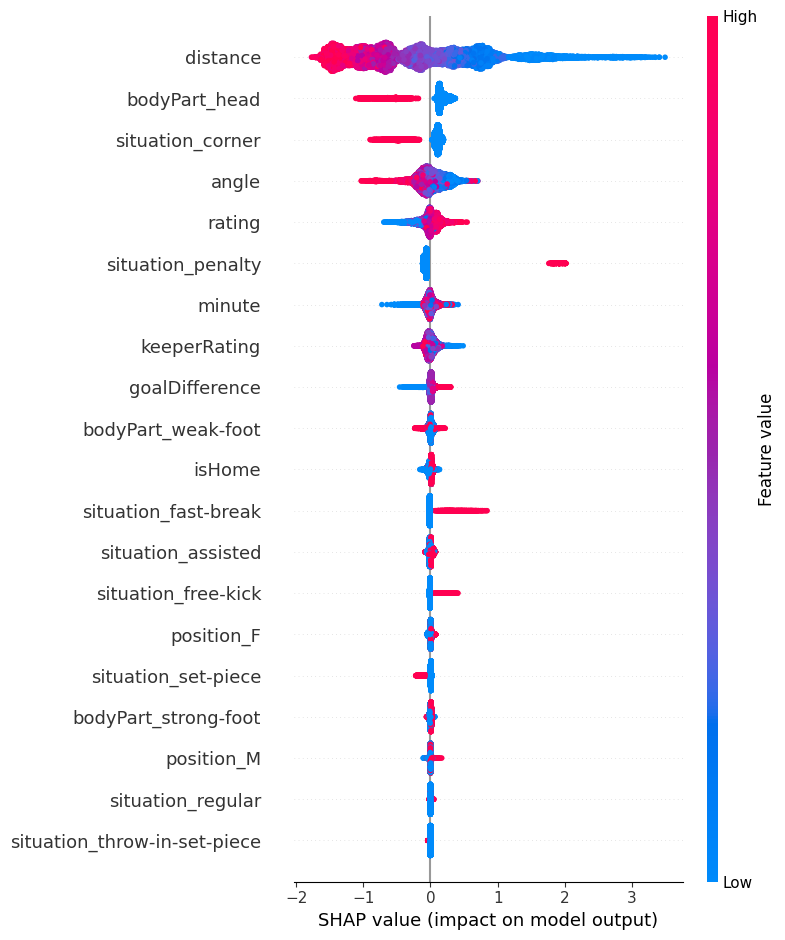

In [45]:
model, X_train, metrics = getPredictions(df, alg="xgb", elo=False, minute=True, home=True, split=True)  #elo and minute are optional since they were not considered previously
joblib.dump(model, basePath + 'modelFiles/' + 'OLD_base_XGB_minute' + '.sav')
explainer = shap.Explainer(model, X_train)
shapValues = explainer(X_train)
shap.summary_plot(shapValues, X_train)

5.2) **Explaining Single Shot**: The *bar* plot tries to explain which features influence a single prediction. Features that go to the right influence positively the prediction, while the ones that go to the left influence negatively the prediction.

[01/07/25 18:19:05] INFO     Saving cached data to /root/soccerdata/data/SoFIFA                      ]8;id=592864;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=588020;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

[01/07/25 18:19:08] INFO     Saving cached data to /root/soccerdata/data/ClubElo                     ]8;id=103547;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=499817;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

                    INFO     Saving cached data to /root/soccerdata/data/Sofascore                   ]8;id=147609;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=627438;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

Accuracy: 0.91
AUC: 0.79
Precision: 0.72
Recall: 0.16
F1 Score: 0.26
New MCC: 0.31


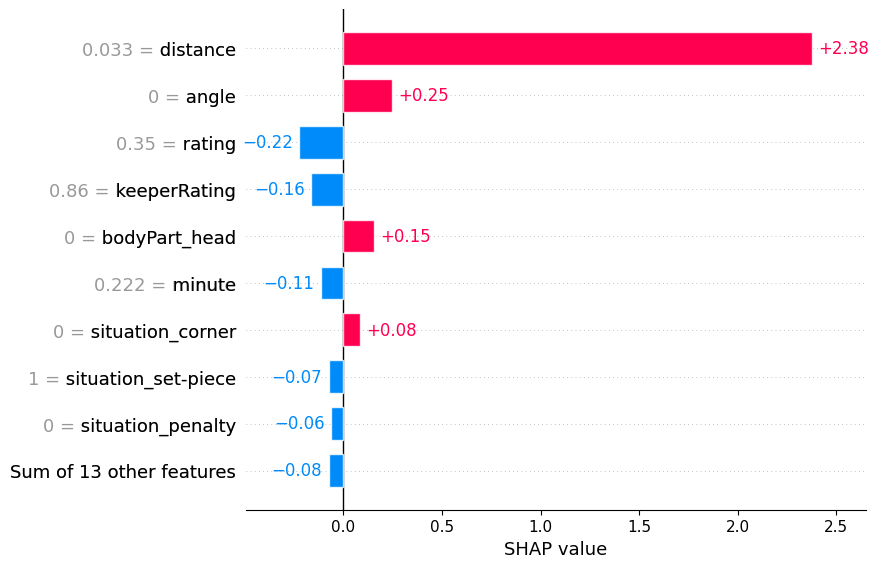

In [54]:
league = "ITA-Serie A"
season = "24-25"
sofifaAll = sd.SoFIFA(leagues=league, versions="all")
versions = sofifaAll.read_versions()
elo = sd.ClubElo()
sofa = sd.Sofascore(leagues=league, seasons=season)
schedule = sofa.read_schedule()
schedule = schedule.droplevel([0,1])
schedule = schedule.reset_index()
game = schedule.loc[1]

df = pd.read_csv(basePath + "seriea_joined_new.csv")
df = df.drop(columns='Unnamed: 0')
df = df.drop(columns=['eloTeam', 'eloOpponent'])


model, X_train, metrics = getPredictions(df, alg="xgb", elo=False, minute=True, home=True, split=True)  #elo and minute are optional since they were not considered previously
joblib.dump(model, basePath + 'modelFiles/' + 'OLD_base_XGB_minute' + '.sav')
stats = predictLocalGame(game, model, elo=False, minute=True, home=True)
stats['homeShots']['xg'] = round(stats['homeShots']['xg'], 2)
stats['homeShots']['xgPred'] = round(stats['homeShots']['xgPred'], 2)
stats['homeShots']['diff'] = round(stats['homeShots']['diff'], 2)
stats['awayShots']['xg'] = round(stats['awayShots']['xg'], 2)
stats['awayShots']['xgPred'] = round(stats['awayShots']['xgPred'], 2)
stats['awayShots']['diff'] = round(stats['awayShots']['diff'], 2)

stats['homeShots_clean'] = stats['homeShots_clean'].reset_index()
stats['homeShots_clean'] = stats['homeShots_clean'].drop(columns=['index'])
shot = stats['homeShots_clean'].loc[2]
explainer = shap.Explainer(model, X_train)
shapValues = explainer(shot)
shap.plots.bar(shapValues)